In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **PROJECT GOAL**
You want to model electricity demand (MW) over time, influenced by:

Temperature

Time features (hour, day of week)

Region

Holidays

In [4]:
import pandas as pd

In [5]:
df= pd.read_excel('/content/drive/MyDrive/electricity_demand_dataset.xlsx')

In [6]:
df.head(100)

,DateTime,Region,Temperature_C,DayOfWeek,Hour,IsHoliday,Demand_MW
0,2024-01-01 00:00:00,West,25.291179,Monday,0,1,237.930201
1,2024-01-01 01:00:00,Central,16.465404,Monday,1,1,273.609093
2,2024-01-01 02:00:00,East,31.127033,Monday,2,1,208.015929
3,2024-01-01 03:00:00,Central,30.089680,Monday,3,1,207.810772
4,2024-01-01 04:00:00,Central,17.601964,Monday,4,1,273.786146
...,...,...,...,...,...,...,...
95,2024-01-04 23:00:00,East,27.845573,Thursday,23,0,287.970486
96,2024-01-05 00:00:00,Central,18.931297,Friday,0,0,319.168888
97,2024-01-05 01:00:00,South,17.437600,Friday,1,0,312.544617
98,2024-01-05 02:00:00,South,23.263420,Friday,2,0,290.552033


In [7]:
df.info() # inspecting the structure of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2184 entries, 0 to 2183
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DateTime       2184 non-null   datetime64[ns]
 1   Region         2184 non-null   object        
 2   Temperature_C  2119 non-null   float64       
 3   DayOfWeek      2184 non-null   object        
 4   Hour           2184 non-null   int64         
 5   IsHoliday      2184 non-null   int64         
 6   Demand_MW      2119 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 119.6+ KB


# **Interpreting the above:**

1. dateTime64: Since this is time series data it tells me that I do not need to do anything with it since it's in the right format.

2. Region& dayOfWeek: These columns are categorical. Meaning that later I will need to encode them if needed- one_hot_encoding or label_encoding.

3. Temperature_C has 65 null (2184- 2119), now I know that I need to fill these nulls with something meangful.

4. Demand_MW also has 65 nulls. This tells me I can use Interpolation to preserve time order.

5. Hour & IsHoliday are numeric: ideal for correlation or modeling. I can possibly convert IsHoliday to T/F/

In [8]:
print(df.describe())

                  DateTime  Temperature_C         Hour    IsHoliday  \
count                 2184    2119.000000  2184.000000  2184.000000   
mean   2024-02-15 11:30:00      22.142485    11.500000     0.032967   
min    2024-01-01 00:00:00       2.563374     0.000000     0.000000   
25%    2024-01-23 17:45:00      18.015811     5.750000     0.000000   
50%    2024-02-15 11:30:00      22.190689    11.500000     0.000000   
75%    2024-03-09 05:15:00      26.285275    17.250000     0.000000   
max    2024-03-31 23:00:00      41.562946    23.000000     1.000000   
std                    NaN       6.093013     6.923772     0.178591   

         Demand_MW  
count  2119.000000  
mean    327.107837  
min     188.180792  
25%     294.311429  
50%     322.684879  
75%     357.563164  
max     519.762752  
std      49.922934  


# **Interpreting the above:**

1. For DateTime
    Min: 2024-01-01 00:00:00
    Max: 2024-03-31 23:00:00

    This tells me I have 3 full months of hourly data (Which is great for time-series)

2. Temperature_C:
  Mean: 22.14^C : mild average
  Min: 2.56^C: very cold
  Max: 41.56^C: Very hot (could be an outlier)
  std: 6.09 : Good variation
  Nulls: about 3% : Clean with median

3. Hour
Ranges from 0 to 23.

Mean is 11.5 → Data is evenly distributed across the day.

I’ll use this to analyze peak demand hours, example:

Morning spikes?

Evening peak between 17:00–21:00?

4. IsHoliday
0 (non-holiday), 1 (holiday)

Mean = 0.0329 → only ~3% of hours are on holidays.

Use this to check if holidays lower demand (they usually do in workplaces, increase it in homes).

5. Demand_MW:
Mean	327 MW	Average usage
Min	188 MW	Low demand period
Max	519 MW	Peak demand
Std	~50 MW	Large variability.
Useful for:

a. Modeling volatility (demand spikes)

b. Detecting high usage hours/regions

c. Checking correlation with temperature

In [9]:
df.isnull().sum()

,0
DateTime,0
Region,0
Temperature_C,65
DayOfWeek,0
Hour,0
IsHoliday,0
Demand_MW,65


In [10]:
# Since I have established that Temperature_C has missing values in different regions, I will
#fill them with the median temperature for each region. Why: to preserve local patterns.

df['Temperature_C']=df.groupby('Region')['Temperature_C'].transform(lambda x: x.fillna(x.median()))

In [11]:
#Checking:

df['Temperature_C'].isnull().sum()

np.int64(0)

In [12]:
# Good, so now the Temperature_C column has been filled with the median temperature using the lambda function

#Now I will handle missing values for the Demand_MW column
#This is my Target column. I cannot lose any rows, so I will interpolate to estimate the missing values, while keeping time continuity.

df['Demand_MW']= df['Demand_MW'].interpolate()

In [13]:
# checking:

df['Demand_MW'].isnull().sum()

np.int64(0)

In [14]:
#Converting IsHoliday to Boolean

df['IsHoliday']= df['IsHoliday'].astype(bool)

In [15]:
#Now making sure that the DateTime column is in datetime format:

df['DateTime']= pd.to_datetime(df['DateTime'])

#then I am creating a clean Date Column (with no time):

df['Date']= df['DateTime'].dt.date

In [16]:
# checking for any left over nulls:

df.isnull().sum()

,0
DateTime,0
Region,0
Temperature_C,0
DayOfWeek,0
Hour,0
IsHoliday,0
Demand_MW,0
Date,0


In [17]:
#Checking again:

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2184 entries, 0 to 2183
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DateTime       2184 non-null   datetime64[ns]
 1   Region         2184 non-null   object        
 2   Temperature_C  2184 non-null   float64       
 3   DayOfWeek      2184 non-null   object        
 4   Hour           2184 non-null   int64         
 5   IsHoliday      2184 non-null   bool          
 6   Demand_MW      2184 non-null   float64       
 7   Date           2184 non-null   object        
dtypes: bool(1), datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 121.7+ KB


,DateTime,Temperature_C,Hour,Demand_MW
count,2184,2184.000000,2184.000000,2184.000000
mean,2024-02-15 11:30:00,22.142933,11.500000,327.343129
min,2024-01-01 00:00:00,2.563374,0.000000,188.180792
25%,2024-01-23 17:45:00,18.169160,5.750000,294.677524
50%,2024-02-15 11:30:00,22.117977,11.500000,323.519840
75%,2024-03-09 05:15:00,26.103790,17.250000,357.555904
max,2024-03-31 23:00:00,41.562946,23.000000,519.762752
std,NaN,6.002090,6.923772,49.556758


In [18]:
# I can see that the 'Date' column is in an object data type. I need to fix this:

df['Date']= pd.to_datetime(df['DateTime'].dt.date)

In [19]:
df.dtypes

,0
DateTime,datetime64[ns]
Region,object
Temperature_C,float64
DayOfWeek,object
Hour,int64
IsHoliday,bool
Demand_MW,float64
Date,datetime64[ns]


In [ ]:
# Okay the Date column is convertet into a date format

## For the ARIMA model, it can't work with text directly. For example a region could be 'Cape Town', 'Johannesburg' etc. So I need to convert those strings into numbers. That is what Encoding is.

Label Encoding: Assigns each unique category a number. So for example, I can make data collected for Cape Town for that day be 0.
 Cape Town = 0, Durban =1, Johannesburg= 2. Since Region is just a label (no rank or order). Note that this is not great for linear models that would think of 2>1 etc.

In [20]:
from sklearn.preprocessing import LabelEncoder

le= LabelEncoder()
df['Region']= le.fit_transform(df['Region'])

# seeing the mapping:
region_mapping= dict(zip(le.classes_, le.transform(le.classes_)))
print(region_mapping)

{'Central': np.int64(0), 'East': np.int64(1), 'North': np.int64(2), 'South': np.int64(3), 'West': np.int64(4)}


In [21]:
# For the above

# .fit(): figures out which unique region exists.
# .transform() : replaces each region with its numeric code

# Mapping just shows me the categories as numbers

But I can see that the Region Column already had been numeric before applying the label encoder since it returned: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), ...}
 So I need to retain the original 'Region' names.



In [22]:
print(df['Region'].unique())
print(df['Region'].dtype)

[4 0 1 3 2]
int64


In [23]:
region_reverse_map= {0: 'Central',
                     1: 'East',
                     2: 'North',
                     3: 'South',
                     4: 'West'

}
df['Region']= df['Region'].map(region_reverse_map)
print(df['Region'].unique())
print(df['Region'].dtype)


['West' 'Central' 'East' 'South' 'North']
object


In [24]:
# Now I'll safely encode:

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Region_Label'] = le.fit_transform(df['Region'])

region_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(region_mapping)


{'Central': np.int64(0), 'East': np.int64(1), 'North': np.int64(2), 'South': np.int64(3), 'West': np.int64(4)}


In [25]:
# Calculating Correlations

corr_Matrix= df.corr(numeric_only= True)

print(corr_Matrix)

               Temperature_C          Hour     IsHoliday  Demand_MW  \
Temperature_C       1.000000 -9.436711e-03  1.476823e-02  -0.714931   
Hour               -0.009437  1.000000e+00  2.584991e-17   0.461566   
IsHoliday           0.014768  2.584991e-17  1.000000e+00  -0.186817   
Demand_MW          -0.714931  4.615657e-01 -1.868169e-01   1.000000   
Region_Label        0.016835 -3.960910e-02 -9.551723e-04  -0.043315   

               Region_Label  
Temperature_C      0.016835  
Hour              -0.039609  
IsHoliday         -0.000955  
Demand_MW         -0.043315  
Region_Label       1.000000  


# **Interpreting the Strength of Correlation:**
Here’s a general guideline for interpreting the magnitude of correlation coefficients:

0.0 to 0.2 (or -0.2 to 0.0): Very weak or negligible correlation.

0.2 to 0.4 (or -0.4 to -0.2): Weak correlation.

0.4 to 0.6 (or -0.6 to -0.4): Moderate correlation.

0.6 to 0.8 (or -0.8 to -0.6): Strong correlation.

0.8 to 1.0 (or -1.0 to -0.8): Very strong or high correlation.

# Interpreting these correlations with respect to Demand_MW:

1. Temperature_C:correlation is -0.71. This is a strong negative correlatio, example: as the temperature increases, there is less electricity demand. It could mean that people may use less electricity in general during hotter months.

2. Hour: correlation is 0.46. This is a moderate correlation, it means that demand increases as the day goes on. This could be because consumption rises during peak times- during evenings people return home and use more appliances.

3. IsHoliday: correlation is -0.19. This is a very weak correlation. Demand tends to decrease during holidays. Could be likely due to fewer businesses are operating, leading to lower electricity use.

4. Region_Label: corrrelation is -0.04. This is a very weak negative correlation with demand. This would mean that REGION itself does not significantly impact demand based on this dataset, other factors do (like temperature etc).


# EDA: To make insights even Clearer

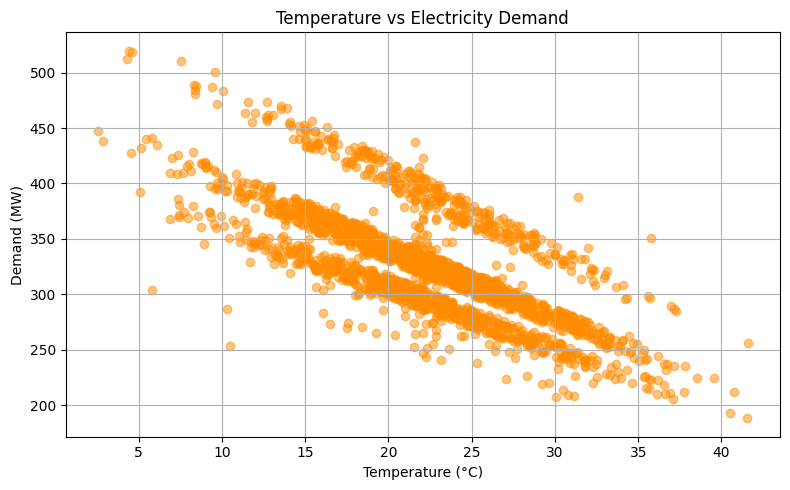

In [28]:
#Since Temperature_C has a strong negative correlation, I will explore it.

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(df['Temperature_C'], df['Demand_MW'], alpha=0.5, color='darkorange')
plt.title('Temperature vs Electricity Demand')
plt.xlabel('Temperature (°C)')
plt.ylabel('Demand (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()

### **Interpretation of this (above diagram):**

1. Downward slope: This means that as Temperature increases, the demand for electricity decreases ---> supports the discovery of -0.71 (strong negative correlation). So with warmer days comes less electricity usage.
2. Outliers: above 450MW when the temperature is still relatively low like <5 degrees--> this makes perfect sense because some people use heaters, electric blankets which use a lot of electricity.
3. I can conclude that according to this dataset, Temperature is inversely related to electricity demand.


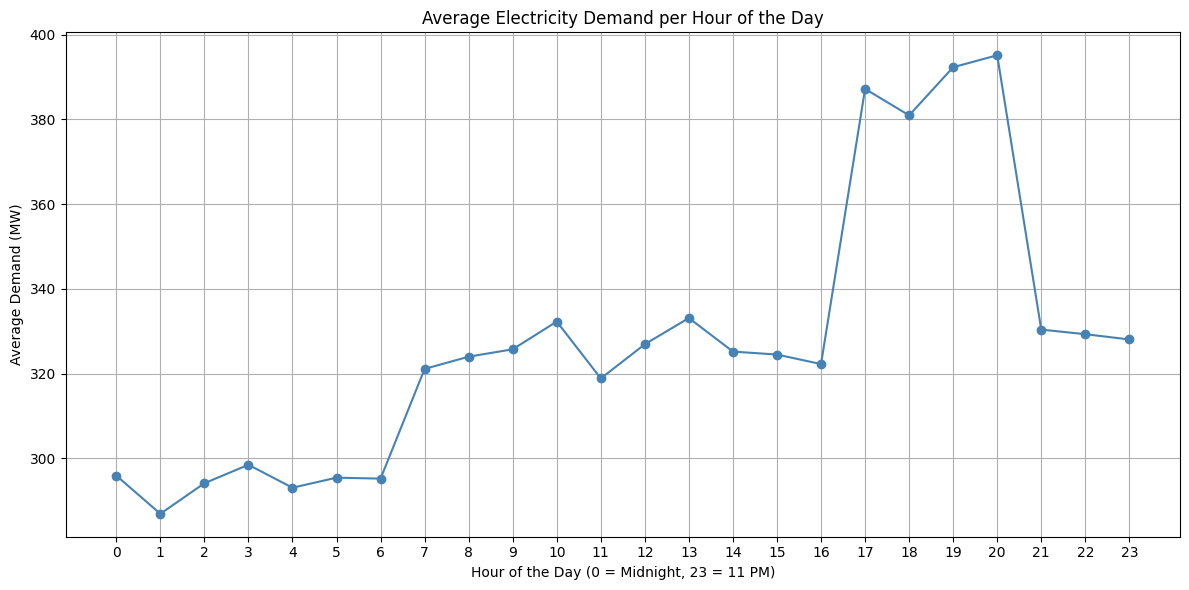

In [31]:
# Now the other moderate correlation was Hoir vs Demand, which I will explore.

import matplotlib.pyplot as plt
import pandas as pd

# Group by hour and calculate the average demand
avg_demand_per_hour = df.groupby('Hour')['Demand_MW'].mean()

# Plotting the line graph
plt.figure(figsize=(12,6))
plt.plot(avg_demand_per_hour.index, avg_demand_per_hour.values, marker='o', linestyle='-', color='steelblue')
plt.title('Average Electricity Demand per Hour of the Day')
plt.xlabel('Hour of the Day (0 = Midnight, 23 = 11 PM)')
plt.ylabel('Average Demand (MW)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


# **Interpretation of this (above line graph):**

1. From 0:00am until 6:00am the demand for electricity is low and steady--> this is expected as most people are asleep and businesses are closed.
2. From 7:00am until 10:00am: There is a noticeable increase --> makes sense because people are waking up and starting to use appliences.
3. 10:00am to 16:00pm : This is midday to afternoon, the demand for electricity is faorly and steadily rising. Businesses are operating at these hours.
4. Then From 17:00pm until 20:00pm: Is th peak demand for electricity, this is likely due to people returning to their homes. People are likely to be using: lights, stoves, tv, computers etc.
5. Then from 21:00pm to 23:00pm: There is a sharp decrease in the demand for electricity. This is due to people going to sleep, usage declines.



In [33]:
# Preparing the Variables

#1. I will be using Demand_MW as the target variable (what I am predicting).
#2. Temperature_C and Hoir will be the features that influence my target variable.
# Thinking of this as Target(y)= how much electricity will be used.
# Then Features(X)= Temperature and Hour of the day.

X=df[['Temperature_C', 'Hour']]
y= df['Demand_MW']

print(X.isnull().sum())
print(y.isnull().sum())

Temperature_C    0
Hour             0
dtype: int64
0


The next step is to check for Stationarity.

Why: ARIMAX model like (ARIMA) assune the time series is stationary. This means the mean, variance, and autocorrelation of the data do not change over time,
--> To check for stationarity, I will use ADF "Augmented Dickey- Fuller test"
Steps:
1. Null Hypothesis: The time series is not stationary.
2. Alternative hypothesis: The time series is stationary.
3. If the p-value of the test is <0.05, the time series is stationary.

In [34]:
from statsmodels.tsa.stattools import adfuller

result= adfuller(y) # ---> perform the ADF test

print(f'ADF Statistic:{result[0]}')
print(f'p-value: {result[1]}')

if result[1]< 0.05:
  print('The time series is stationary.')
else:
  print('The time series is not stationary.')

ADF Statistic:-7.014694574020545
p-value: 6.780073242801896e-10
The time series is stationary.


# Interpretation of the ADF test and the p value:

1. ADF statistic: I obtained a negative value, so this indicates that the series is stationary.
2. p-value: this is a very very small p value "<0.05" tells me to reject the null hypothesis, and accept that the series is stationary.

# **Next: Fitting the ARIMAX Model**

First:
I have to find p (PACF),d and q (ACF):

1. d "differencing" = 1 is often used when the series is not stationary (but I have already discovered that it is)
2. p "Autoregressive Order" : indicates **how many past values**, called "lags" the model should consider to predict future values. To find p, I need to use the PACF plot. **For example if I say p=1, it would mean I want to use 1 past value to predict the current value.** For more clarity again: In this** I want to predict electricity demand for today, so I will look at yesterday's electricity demand to make the prediction. **
3. q "moving average": tells how many previous prediction errors called **residuals** I want my model to use. It helps my model correct any mistakes the model might have made in previous predictions. **Example: In predicting electricity demand, the model will consider how much it over/under estimated in the last 2 periods and correct its prediction accordingly**.

ACF plot: tells me how many mistakes or errors (residuals) are correlated with current values. If I see significant spikes in the ACF up to a certain lag (say lag 4), and then the spikes drop off near zero, it will tell me that the errors up to lag 4 still affect the prediction, but beyond that there isn't much contribution.

PACF plot: helps me determine the number of lags in the autoregressive model by showing me partial correlation.  

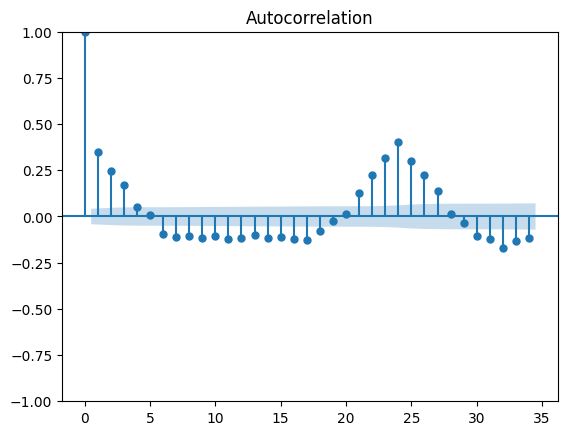

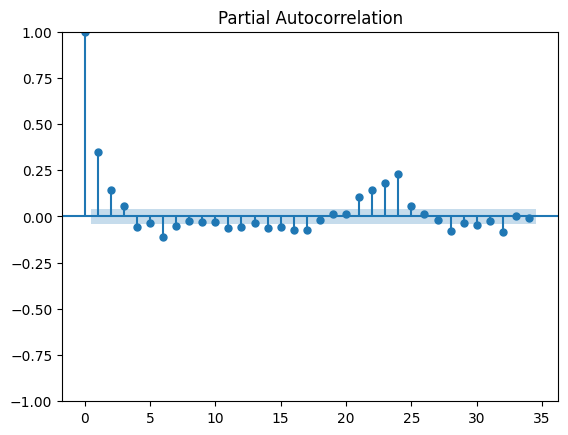

In [35]:
# determining p:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# ACF and PACF plots to determine p and q:
plot_acf(y)
plt.show()

plot_pacf(y)
plt.show()


In [36]:
# Calculating the ACF and PACF numerically:

from statsmodels.tsa.stattools import acf, pacf
import pandas as pd

acf_values= acf(df['Demand_MW'], nlags=20)
pacf_values= pacf(df['Demand_MW'], nlags= 20)

acf_df= pd.DataFrame({'Lag': range(len(acf_values)), 'ACF': acf_values})
pacf_df= pd.DataFrame({'Lag': range(len(pacf_values)), 'PACF': pacf_values})

print("ACF Values:")
print(acf_values)
print("\nPACF Values:")
print(pacf_values)

ACF Values:
[ 1.          0.34712383  0.24542656  0.17151296  0.05076676  0.00653203
 -0.09552012 -0.11097203 -0.1066255  -0.114502   -0.10326516 -0.1205508
 -0.11880888 -0.10080486 -0.11496457 -0.11187224 -0.12456933 -0.12493364
 -0.07728582 -0.02477902  0.01566826]

PACF Values:
[ 1.          0.34728284  0.14219571  0.05708706 -0.05762463 -0.03412836
 -0.11047245 -0.05282296 -0.02550682 -0.0320418  -0.02963407 -0.06091515
 -0.05767649 -0.03781317 -0.06275942 -0.05854856 -0.07649103 -0.07326745
 -0.02037416  0.01540405  0.01410486]


# Intepretation:

**p=1**
**and q=4**

# **Next: Is to Fit the ARIMAX Model**

In [40]:
# Importing necessary libraries
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# 'Temperature_C' (exogenous), 'Hour' (exogenous), and 'Demand_MW' (dependent variable)

y = df['Demand_MW']  # Dependent variable: Electricity Demand
X = df[['Temperature_C', 'Hour']]  # Exogenous variables: Temperature and Hour

# Fitting the ARIMAX model (p=1, d=0, q=4)
model = ARIMA(y, exog=X, order=(1, 0, 4))  # AR(p=1), I(d=0), MA(q=4)
model_fit = model.fit()

# Printing the summary of the fitted model
print(model_fit.summary())

# Making predictions (forecasting for the next 5 time steps)
forecast_steps = 5
forecast = model_fit.forecast(steps=forecast_steps, exog=X[-forecast_steps:])
print("Forecasted Demand for next 5 periods:", forecast)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:              Demand_MW   No. Observations:                 2184
Model:                 ARIMA(1, 0, 4)   Log Likelihood               -9821.198
Date:                Thu, 10 Apr 2025   AIC                          19660.396
Time:                        00:39:44   BIC                          19711.596
Sample:                             0   HQIC                         19679.112
                               - 2184                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           435.8707      2.474    176.160      0.000     431.021     440.720
Temperature_C    -5.9286      0.061    -97.023      0.000      -6.048      -5.809
Hour              1.9842      0.137     

In [47]:
import pandas as pd

# Forecast the next 5 periods

forecasted_demand = model_fit.predict(start=len(df), end=len(df)+4, dynamic=False, exog=X[-5:]) # Adding exog for exogenous variables

# Now let's create a starting point, like the last date and hour from your data
last_date = pd.to_datetime('2025-04-10')  # last date from my dataset
last_hour = 9  # Example: assuming the last hour was 9 AM
# Generate the next 5 days for the forecast
forecast_dates = pd.date_range(last_date, periods=6, freq='D')[1:]  # starting from the next day
forecast_hours = [last_hour + i for i in range(1, 6)]  # Assign next hour for each forecasted day

# Assume constant temperatures for simplicity
forecast_temperatures = [25, 26, 27, 28, 29]
# Creating a DataFrame with Date, Temperature_C, Hour, and Predicted_Demand_MW
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Temperature_C': forecast_temperatures,
    'Hour': forecast_hours,
    'Predicted_Demand_MW': forecasted_demand
})

# Display the DataFrame
print(forecast_df)

           Date  Temperature_C  Hour  Predicted_Demand_MW
2184 2025-04-11             25    10           352.732515
2185 2025-04-12             26    11           368.865305
2186 2025-04-13             27    12           294.895880
2187 2025-04-14             28    13           362.206774
2188 2025-04-15             29    14           370.863799
